# Design assignment

### Import the neccesary packages

Add all needed packages here, so we can import them in one go

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt


### Import Data, split between input (u) and output (th)

The sampling time is 25ms (see discussion forum).

**Beetje omslachtig gedaan nu, maar het werkt**

In [4]:
data = pd.read_csv(r'disc-benchmark-files\training-data.csv')

u = data.iloc[:, 0].to_numpy()
th = data.iloc[:, 1].to_numpy()

### Create Neural Network

One hidden layer, n nodes.

In [17]:
class Network(nn.Module):
    def __init__(self, n):
        super(Network,self).__init__()
        self.lay1 = nn.Linear(1,n).double()
        self.lay2 = nn.Linear(n,n).double()
        self.lay3 = nn.Linear(n,1).double()
        
    def forward(self,u):
        u = u[:,None]
        x1 = torch.sigmoid(self.lay1(u)) 
        x2 = torch.sigmoid(self.lay2(x1)) 
        y = self.lay3(x2)[:,0]            
        return y

**Keiharde copy paste van L3 doen? Waar komt Guassian om de hoek kijken?**

In [31]:
from data import load_data
data_train_u, data_train_y = load_data(train_test='train', as_tensor=False)
data_test_u, data_test_y = load_data(train_test = 'test', as_tensor=False)
data_test_u = data_train_u[60000:80000]
data_train_u = data_train_u[0:59999]
data_test_y=data_train_y[60000:80000]
data_train_y=data_train_y[0:59999]
print(data_train_u)
print(data_train_y)
print(data_test_u)
print(len(data_train_u))
print(len(data_train_y))
print(len(data_test_u))
print(len(data_test_y))

u_mean, u_std = np.mean(data_train_u),np.std(data_train_u)
y_mean, y_std = np.mean(data_train_y),np.std(data_train_y)

### Data to train and validate on ###:
utrain = (data_train_u-u_mean)/u_std #normalize
ytrain = (data_train_y-y_mean)/y_std 

uval = (data_test_u-u_mean)/u_std
yval = (data_test_y-y_mean)/y_std







[-0.65753336 -1.15836453 -1.4437682  ... -1.48722401  0.78445502
  1.48946713]
[ 0.         -0.00314159 -0.01570796 ...  1.00530965  0.73199109
  0.41783182]
[-1.6208703  -1.54383557  1.71739947 ...  1.9475897   1.64675509
  1.21097478]
59999
59999
20000
20000


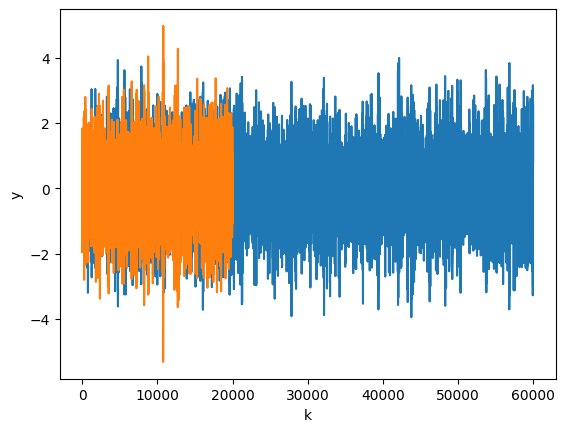

In [33]:
plt.plot(ytrain)
plt.plot(yval)
plt.xlabel('k')
plt.ylabel('y')
plt.show()

In [34]:
def make_OE_data(udata, ydata, nf=100):
    U = [] 
    Y = [] 
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(U), np.array(Y)

nfuture = 30
convert = lambda x: [torch.tensor(xi,dtype=torch.float64) for xi in x]
Utrain, Ytrain = convert(make_OE_data(utrain, ytrain, nf=nfuture))
Uval,   Yval   = convert(make_OE_data(uval,  yval,   nf=len(data_test_u)))

class simple_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(simple_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40), \
                                               nn.Sigmoid(), \
                                               nn.Linear(40,n_out)).double() #new short hand
        self.h2h = net(self.input_size + hidden_size, self.hidden_size)
        self.h2o = net(self.input_size + hidden_size, self.output_size)
                                                                        #[:,0] should be called after use of h2o

    def forward(self, inputs):
        hidden = torch.zeros(inputs.shape[0], self.hidden_size, dtype = torch.float64)
        outputs = []
        for i in range(inputs.shape[1]):
            u = inputs[:,i]
            combined = torch.cat((hidden, u[:,None]), dim=1)
            outputs.append(self.h2o(combined)[:,0])
            hidden = self.h2h(combined)
        return torch.stack(outputs,dim=1)
    

In [35]:
n_burn = 10
batch_size = 64

model = simple_RNN(hidden_size=15)
optimizer = torch.optim.Adam(model.parameters())


ids = np.arange(len(Utrain),dtype=int) 
for epoch in range(50):
    np.random.shuffle(ids) #inspace shuffle of the ids of the trainin set to select a random subset 
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now]
        Y_real = Ytrain[ids_now]

        y_predict = model.forward(inputs=Uin)
        residual = Y_real - y_predict
        Loss = torch.mean(residual[:,n_burn:]**2)

        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    with torch.no_grad(): #monitor
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

epoch=0, Validation NRMS=49.42%, Train NRMS=66.03%
epoch=1, Validation NRMS=45.01%, Train NRMS=69.95%
epoch=2, Validation NRMS=48.12%, Train NRMS=66.21%
epoch=3, Validation NRMS=42.23%, Train NRMS=65.12%
epoch=4, Validation NRMS=40.99%, Train NRMS=62.84%
epoch=5, Validation NRMS=40.44%, Train NRMS=62.97%
epoch=6, Validation NRMS=39.76%, Train NRMS=62.80%
epoch=7, Validation NRMS=41.12%, Train NRMS=63.74%
epoch=8, Validation NRMS=46.00%, Train NRMS=64.50%
epoch=9, Validation NRMS=44.39%, Train NRMS=63.68%
epoch=10, Validation NRMS=42.29%, Train NRMS=64.07%
epoch=11, Validation NRMS=42.13%, Train NRMS=63.27%
epoch=12, Validation NRMS=42.46%, Train NRMS=65.52%
epoch=13, Validation NRMS=42.36%, Train NRMS=64.19%
epoch=14, Validation NRMS=45.64%, Train NRMS=64.02%
epoch=15, Validation NRMS=40.34%, Train NRMS=62.83%
epoch=16, Validation NRMS=40.95%, Train NRMS=62.79%
epoch=17, Validation NRMS=40.94%, Train NRMS=63.19%
epoch=18, Validation NRMS=39.99%, Train NRMS=63.69%
epoch=19, Validation N

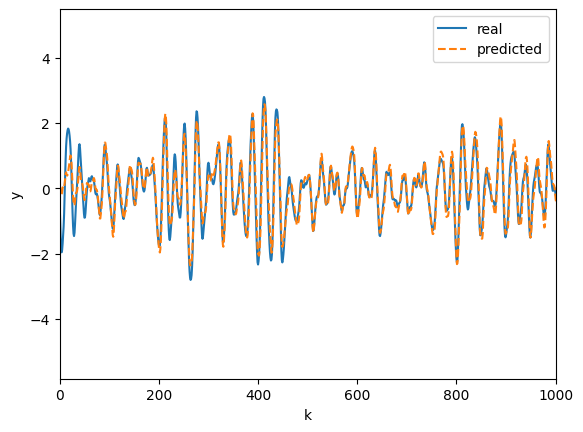

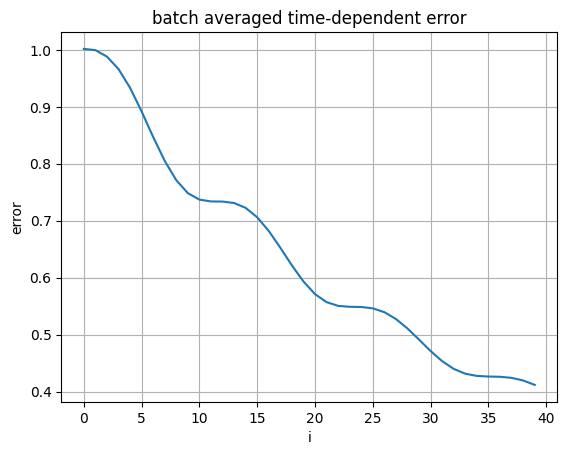

In [47]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,1000)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain)).numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()


In [37]:
def make_OE_init_state_data(udata, ydata, nf=100, n_encode=20):
    U = [] 
    Y = [] 
    hist = [] 
    for k in range(nf+n_encode,len(udata)+1):
        hist.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf])))
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(hist), np.array(U), np.array(Y)

nfuture = 35
n_encode = 20
convert = lambda x: [torch.tensor(xi, dtype=torch.float64) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(utrain, ytrain, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(uval,   yval,   nf=len(uval)-n_encode, n_encode=n_encode))

In [38]:
class simple_encoder_RNN(nn.Module):
    def __init__(self, hidden_size, n_encoder=20):
        super(simple_encoder_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)).double() #short hand for a 1 hidden layer NN
        self.h2h = net(self.input_size + hidden_size, self.hidden_size)
        self.h2o = net(self.input_size + hidden_size, self.output_size)
        self.encoder = net(n_encoder*2,hidden_size).double()

    def forward(self,inputs,hist):
        hidden = self.encoder(hist)
        outputs = []
        for i in range(inputs.shape[1]):
            input = inputs[:,i]
            combined = torch.cat((hidden, input[:,None]), 1)
            outputs.append(self.h2o(combined)[:,0])
            hidden = self.h2h(combined)
        return torch.stack(outputs,dim=1)

In [39]:
model = simple_encoder_RNN(hidden_size=15, n_encoder=n_encode)
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64

ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    np.random.shuffle(ids)
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Y_real = Ytrain[ids_now]

        Y_predict = model.forward(inputs=Uin, hist=histin)
        residual = Y_real - Y_predict 
        Loss = torch.mean(residual**2) #no burn time
        
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval,hist=histval) - Yval)**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain) - Ytrain)**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}')

epoch=0, Validation Loss=35.62%, Train Loss=21.13%
epoch=1, Validation Loss=34.60%, Train Loss=18.94%
epoch=2, Validation Loss=33.72%, Train Loss=17.40%
epoch=3, Validation Loss=35.05%, Train Loss=19.85%
epoch=4, Validation Loss=31.77%, Train Loss=16.10%
epoch=5, Validation Loss=32.45%, Train Loss=17.05%
epoch=6, Validation Loss=31.21%, Train Loss=15.02%
epoch=7, Validation Loss=30.73%, Train Loss=15.11%
epoch=8, Validation Loss=27.39%, Train Loss=11.26%
epoch=9, Validation Loss=22.85%, Train Loss=7.23%
epoch=10, Validation Loss=21.99%, Train Loss=7.29%
epoch=11, Validation Loss=23.37%, Train Loss=7.58%
epoch=12, Validation Loss=21.66%, Train Loss=6.94%
epoch=13, Validation Loss=22.38%, Train Loss=7.09%
epoch=14, Validation Loss=21.93%, Train Loss=6.88%
epoch=15, Validation Loss=22.61%, Train Loss=9.85%
epoch=16, Validation Loss=21.15%, Train Loss=6.18%
epoch=17, Validation Loss=21.12%, Train Loss=6.09%
epoch=18, Validation Loss=21.27%, Train Loss=6.60%
epoch=19, Validation Loss=22.83%

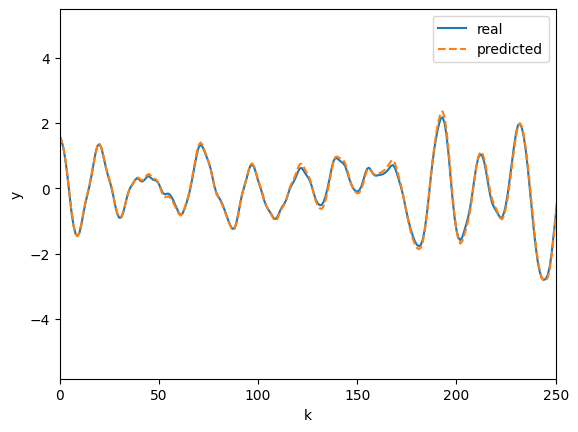

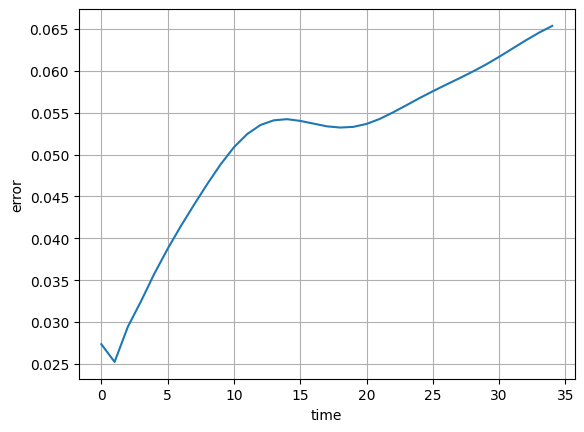

In [40]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval,hist=histval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain,hist=histtrain)).numpy()**2,axis=0)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.grid()
    plt.show()

In [41]:
def make_OE_data(udata,ydata,nf=100):
    U = [] #[u[k-nf],...,u[k]]
    Y = [] #[y[k-nf],...,y[k]]
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(U),np.array(Y)

nfuture = 40
convert = lambda x: [torch.tensor(xi,dtype=torch.float64) for xi in x]
Utrain,Ytrain = convert(make_OE_data(utrain,ytrain,nf=nfuture))
Uval,Yval = convert(make_OE_data(uval,yval,nf=len(uval)))

class simple_lstm(nn.Module):
    def __init__(self, hidden_size):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size = hidden_size, batch_first=True).double()
        self.h2o = net(hidden_size + self.input_size, self.output_size).double()
    def forward(self, inputs):
        hiddens, (h_n,c_n)= self.lstm(inputs[:,:,None])
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2)
        h2o_input = combined.view(-1,self.hidden_size + self.input_size)
        y_predict= self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])
        return y_predict

n_burn = 20
model = simple_lstm(hidden_size=15)
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64

for epoch in range(50):
    for i in range(0,len(Utrain),batch_size):
        Uin = Utrain[i:i+batch_size]
        Yout = model.forward(inputs=Uin)
        Yin = Ytrain[i:i+batch_size]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}')

epoch=0, Validation Loss=44.08%, Train Loss=52.16%
epoch=1, Validation Loss=40.37%, Train Loss=50.88%
epoch=2, Validation Loss=38.45%, Train Loss=50.38%
epoch=3, Validation Loss=37.20%, Train Loss=50.10%
epoch=4, Validation Loss=36.30%, Train Loss=49.92%
epoch=5, Validation Loss=35.61%, Train Loss=49.78%
epoch=6, Validation Loss=35.06%, Train Loss=49.68%
epoch=7, Validation Loss=34.62%, Train Loss=49.59%
epoch=8, Validation Loss=34.26%, Train Loss=49.52%
epoch=9, Validation Loss=33.96%, Train Loss=49.46%
epoch=10, Validation Loss=33.72%, Train Loss=49.41%
epoch=11, Validation Loss=33.52%, Train Loss=49.37%
epoch=12, Validation Loss=33.35%, Train Loss=49.33%
epoch=13, Validation Loss=33.21%, Train Loss=49.30%
epoch=14, Validation Loss=33.09%, Train Loss=49.27%
epoch=15, Validation Loss=33.00%, Train Loss=49.24%
epoch=16, Validation Loss=32.91%, Train Loss=49.22%
epoch=17, Validation Loss=32.84%, Train Loss=49.19%
epoch=18, Validation Loss=32.78%, Train Loss=49.17%
epoch=19, Validation L

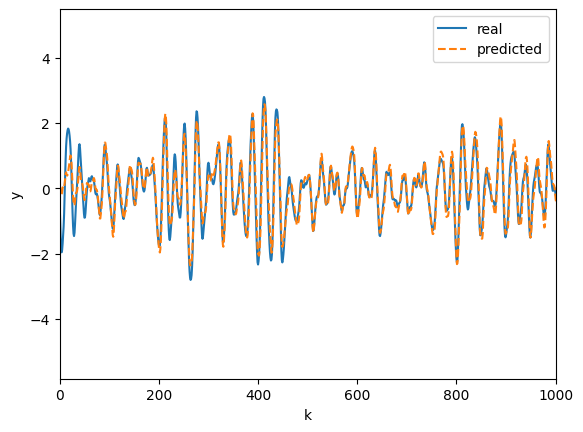

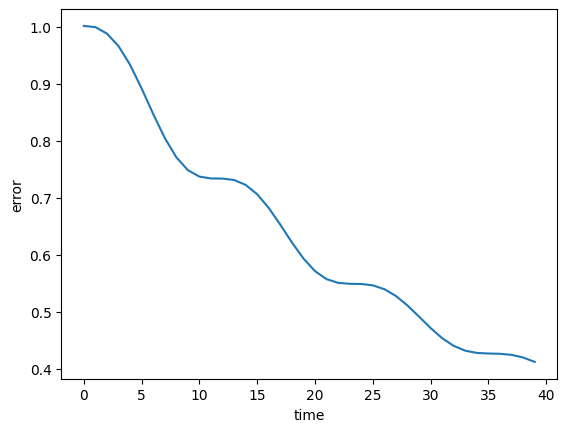

In [46]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,1000)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain)).numpy()**2,axis=0)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.show()